In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np

tf.config.experimental.set_memory_growth(
    tf.config.experimental.list_physical_devices('GPU')[0],
    True
)

Load the data.

In [2]:
sunspots = pd.read_csv('monthly_sunspots.csv')['Sunspots']

Standardize the data to work with it effectively.

In [3]:
sunspots_mean = sunspots.mean()
sunspots_std = sunspots.std()
sunspots_normed = (sunspots - sunspots_mean) / sunspots_std

In [4]:
def prepare_inputs_and_targets(ts, len_in, len_out):
    num_seqs = len(ts) - len_in - len_out
    seqs_in = [ts[i:i+len_in] for i in range(num_seqs)]
    seqs_out = [ts[len_in+i:len_in+i+len_out] for i in range(num_seqs)]
    return np.stack(seqs_in), np.stack(seqs_out)

We will use 1/5 of the series as input and predict 1/5 of the series.

In [5]:
seq_len_in = len(sunspots) // 5
seq_len_out = len(sunspots) // 5
seqs_in, seqs_out = prepare_inputs_and_targets(sunspots_normed, seq_len_in, seq_len_out)

Prepare the neural network.

In [16]:
inputs = keras.layers.Input(shape=(seq_len_in, 1))
lstm = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(seq_len_out)(lstm)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-1), loss="mse")
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 564, 1)]          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_4 (Dense)              (None, 564)               18612     
Total params: 22,964
Trainable params: 22,964
Non-trainable params: 0
_________________________________________________________________


Train the network.

In [17]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.95

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit(
    seqs_in.reshape(-1, seq_len_in, 1),
    seqs_out,
    epochs=100,
    callbacks=[lr_scheduler]
)

Epoch 1/100
53/53 [==============================] - 2s 15ms/step - loss: 0.9064
Epoch 2/100
53/53 [==============================] - 1s 15ms/step - loss: 0.6826
Epoch 3/100
53/53 [==============================] - 1s 16ms/step - loss: 0.6997
Epoch 4/100
53/53 [==============================] - 1s 15ms/step - loss: 0.6568
Epoch 5/100
53/53 [==============================] - 1s 15ms/step - loss: 0.6637
Epoch 6/100
53/53 [==============================] - 1s 15ms/step - loss: 0.9135
Epoch 7/100
53/53 [==============================] - 1s 16ms/step - loss: 0.7946
Epoch 8/100
53/53 [==============================] - 1s 16ms/step - loss: 0.7329
Epoch 9/100
53/53 [==============================] - 1s 15ms/step - loss: 0.6723
Epoch 10/100
53/53 [==============================] - 1s 15ms/step - loss: 0.6588
Epoch 11/100
53/53 [==============================] - 1s 15ms/step - loss: 0.6292
Epoch 12/100
53/53 [==============================] - 1s 16ms/step - loss: 0.5678
Epoch 13/100
53/53 [=====

Test the network and evaluate the forecast against the actual future.

MAPE: 0.35711378612358846


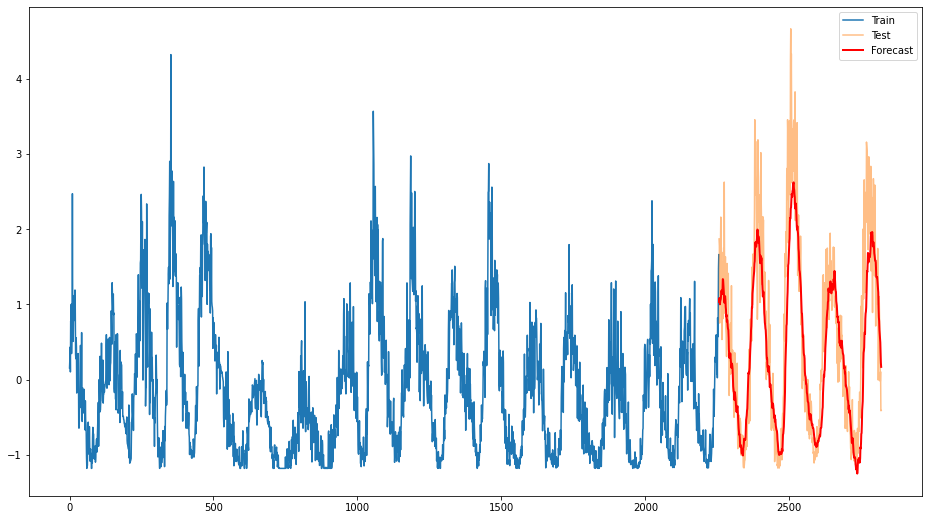

In [18]:
true_past = sunspots_normed[:-seq_len_out]
true_future = sunspots_normed[-seq_len_out:]
seq_in = sunspots_normed[-(seq_len_out+seq_len_in):-seq_len_out].values
forecast = model.predict(seq_in.reshape(1, -1, 1))[-1]

mape = np.median(np.abs((true_future - forecast)/true_future))
print(f'MAPE: {mape}')

plt.figure(figsize=(16, 9))
plt.plot(true_past, label='Train')
x = np.arange(len(forecast)) + len(true_past)
plt.plot(x, true_future, label='Test', alpha=0.5)
plt.plot(x, forecast, label='Forecast', color='red', linewidth=2)
plt.legend()